In [43]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rough_path_signatures_pricing.signature_regressor as sr
import rough_path_signatures_pricing.simulation_models as sm

importlib.reload(sm)
importlib.reload(sr)

<module 'rough_path_signatures_pricing.signature_regressor' from 'C:\\Users\\chris\\VSCodeProjects\\rough-path-signatures-pricing\\src\\rough_path_signatures_pricing\\signature_regressor.py'>

In [44]:
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / "data"
IMG_DIR = PROJECT_DIR / "img"
DATA_DIR.mkdir(exist_ok=True)
IMG_DIR.mkdir(exist_ok=True)

plt.rcParams.update(
    {
        "font.size": 16,
    }
)
FIG_SIZE = (10, 6)

#### GBM Paths for Fitting Linear Functional with Signature to Approximate Payoffs

Simulation setup

In [45]:
# Simulation parameters
N_PATHS = 10000
SEED = 43
X0 = 6900
STRIKES = np.arange(X0 - 25 * 25, X0 + 25 * 25, 25)
N_STEPS = 252
MU = 0.08
SIGMA = 0.3

# Fitting parameters
N = 5
LAM = 0  # Lambda for ridge regression
FRAC = 0.5
SPLIT_SEED = 42

# Price parameters
BARRIER_OUT = 7800
BARRIER_IN = 7300

In [46]:
GBM_CONFIG = {
    "x0": X0,
    "t0": 0,
    "t1": 1,
    "n_steps": N_STEPS,
    "seed": SEED,
    "mu": MU,
    "sigma": SIGMA,
}

Train and prediction setup

In [47]:
def barrier_up_out_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(ST - K, 0) if barrier not hit"""
    max_prices = np.max(paths, axis=1)
    payoffs = np.maximum(paths[:, -1] - strike, 0.0)
    payoffs[max_prices > BARRIER_OUT] = 0.0
    return payoffs


def barrier_up_in_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(ST - K, 0) if barrier hit"""
    max_prices = np.max(paths, axis=1)
    payoffs = np.maximum(paths[:, -1] - strike, 0.0)
    payoffs[max_prices < BARRIER_IN] = 0.0
    return payoffs


def european_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(ST - K, 0)"""
    return np.maximum(paths[:, -1] - strike, 0.0)


def european_put_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(K - ST, 0)"""
    return np.maximum(strike - paths[:, -1], 0.0)


def asian_fixed_strike_call_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(Average - K, 0)"""
    average_price = np.mean(paths, axis=1)
    return np.maximum(average_price - strike, 0.0)


def asian_fixed_strike_put_payoff(paths: np.ndarray, strike: float) -> np.ndarray:
    """Payoff = max(K - Average, 0)"""
    average_price = np.mean(paths, axis=1)
    return np.maximum(strike - average_price, 0.0)

Simulated prices prediction

In [48]:
price_models = ["GBM", "JumpDiffusion", "RoughVolatility"]
payoff_configs = [
    (european_call_payoff, "European_Call"),
    (asian_fixed_strike_call_payoff, "Asian_Call"),
    (barrier_up_out_call_payoff, "UO_Barrier_Call"),
    (barrier_up_in_call_payoff, "UI_Barrier_Call"),
]

--- Evaluating Model: GBM ---
  Fitting European_Call...
  Fitting Asian_Call...
  Fitting Asian_Call...
  Fitting UO_Barrier_Call...
  Fitting UO_Barrier_Call...
  Fitting UI_Barrier_Call...
  Fitting UI_Barrier_Call...


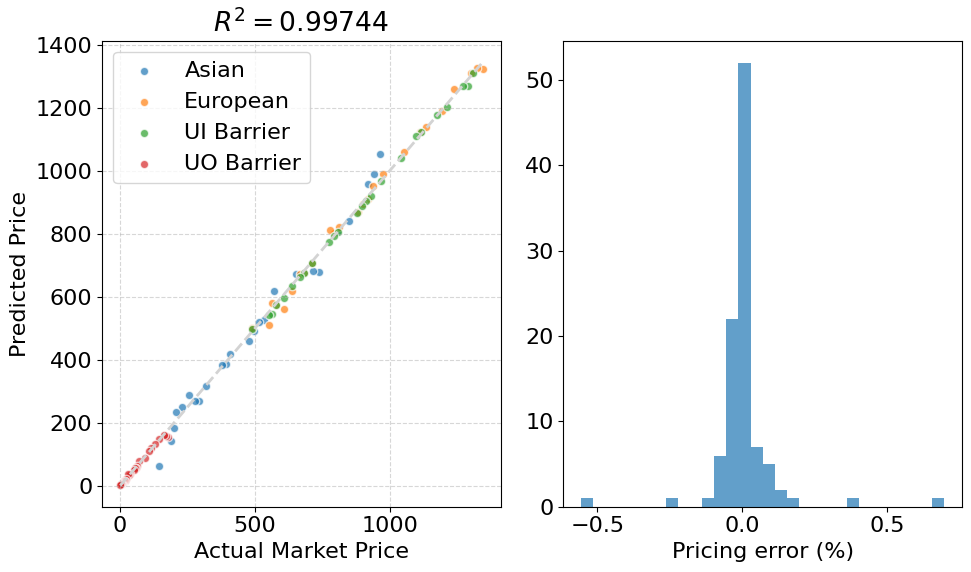

Saved plot to c:\Users\chris\VSCodeProjects\rough-path-signatures-pricing\img\GBM.png
--- Evaluating Model: JumpDiffusion ---
  Fitting European_Call...
  Fitting Asian_Call...
  Fitting Asian_Call...
  Fitting UO_Barrier_Call...
  Fitting UO_Barrier_Call...
  Fitting UI_Barrier_Call...
  Fitting UI_Barrier_Call...


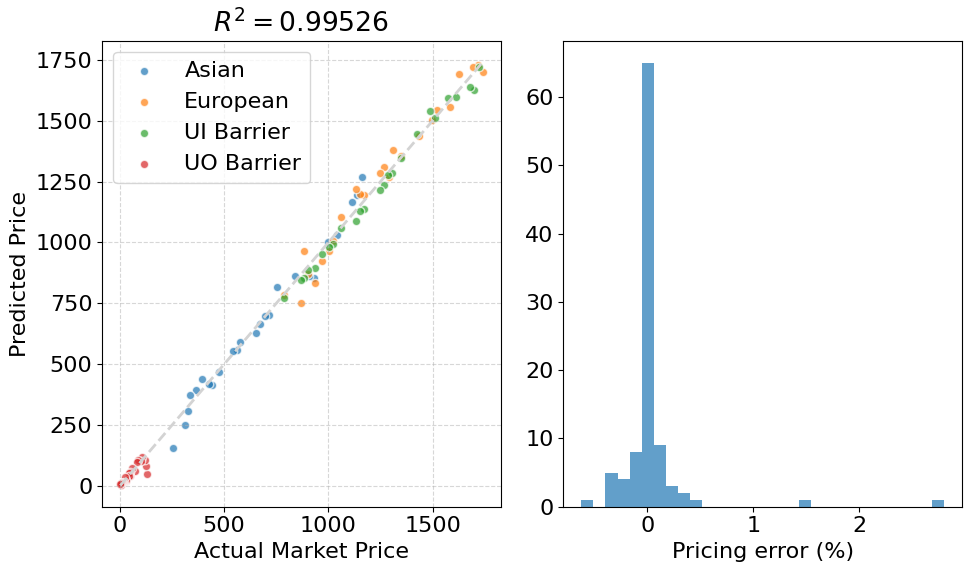

Saved plot to c:\Users\chris\VSCodeProjects\rough-path-signatures-pricing\img\JumpDiffusion.png
--- Evaluating Model: RoughVolatility ---
  Fitting European_Call...
  Fitting Asian_Call...
  Fitting Asian_Call...
  Fitting UO_Barrier_Call...
  Fitting UO_Barrier_Call...
  Fitting UI_Barrier_Call...
  Fitting UI_Barrier_Call...


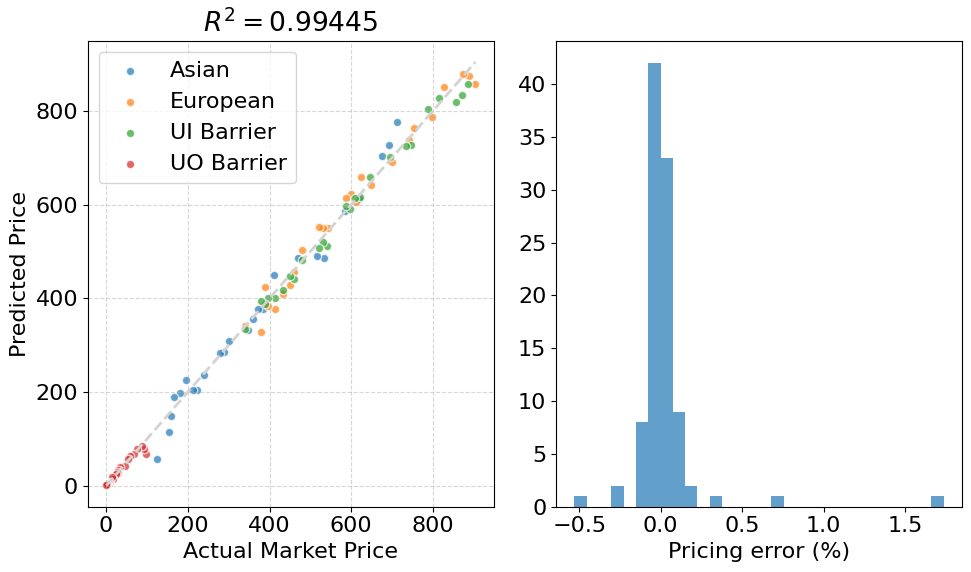

Saved plot to c:\Users\chris\VSCodeProjects\rough-path-signatures-pricing\img\RoughVolatility.png


In [ ]:
# Main Loop over Models
for model_name in price_models:
    print(f"--- Evaluating Model: {model_name} ---")

    # 1. Initialize Simulator
    simulator = sm.GBM(**GBM_CONFIG)

    model_results = []

    # 2. Loop over Payoffs
    for payoff_func, payoff_name in payoff_configs:
        filename = f"{model_name}_{payoff_name}.csv"
        file_path = DATA_DIR / filename

        print(f"  Fitting {payoff_name}...")

        # 3. Read Data
        df = pd.read_csv(file_path)

        # 4. Train/Test Split
        train_df = df.sample(frac=FRAC, random_state=SPLIT_SEED)
        test_df = df.drop(train_df.index).copy()

        X_train = train_df["param"].values
        y_train = train_df["price"].values
        X_test = test_df["param"].values
        y_test = test_df["price"].values

        # 5. Initialize and Fit Pricer
        pricer = sr.SignaturePricer(
            simulator=simulator, func=payoff_func, signature_degree=N
        )
        pricer.fit(X=X_train, y=y_train, n_paths=N_PATHS, lam=LAM)

        # 6. Predict
        y_pred = pricer.predict(X=X_test)

        # 7. Store Results
        test_df["predicted_price"] = y_pred
        test_df["payoff_type"] = (
            payoff_name.replace("_", " ").removesuffix(" Call").strip()
        )
        model_results.append(test_df)

    if not model_results:
        print(f"No results generated for {model_name}.")
        continue

    # 8. Consolidate Results for Plotting
    full_model_df = pd.concat(model_results, ignore_index=True)

    # Calculate R^2 on the whole set
    y_true_all = full_model_df["price"].values
    y_pred_all = full_model_df["predicted_price"].values

    ss_res = np.sum((y_true_all - y_pred_all) ** 2)
    ss_tot = np.sum((y_true_all - np.mean(y_true_all)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # 9. Plotting
    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # --- Plot 1: Scatter (Actual vs Predicted) ---
    ax_scatter = axes[0]
    groups = full_model_df.groupby("payoff_type")
    for name, group in groups:
        ax_scatter.scatter(
            group["price"],
            group["predicted_price"],
            label=name,
            alpha=0.7,
            edgecolors="w",
        )

    # Identity Line
    min_val = min(y_true_all.min(), y_pred_all.min())
    max_val = max(y_true_all.max(), y_pred_all.max())
    ax_scatter.plot(
        [min_val, max_val], [min_val, max_val], "--", lw=2, color="lightgrey"
    )

    ax_scatter.set_xlabel("Actual Market Price")
    ax_scatter.set_ylabel("Predicted Price")
    ax_scatter.set_title(f"$R^2 = {r2:.5f}$")
    ax_scatter.legend()
    ax_scatter.grid(True, linestyle="--", alpha=0.5)

    # --- Plot 2: Histogram (Pricing Errors) ---
    ax_hist = axes[1]
    errors = (y_pred_all - y_true_all) / y_true_all
    ax_hist.hist(errors, bins=30, alpha=0.7)

    ax_hist.set_xlabel("Pricing error (%)")
    ax_hist.set_ylabel("")
    ax_hist.set_title("")

    plt.tight_layout()

    # Save Plot
    save_path = IMG_DIR / f"{model_name}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Saved plot to {save_path}")

--- Evaluating Model on SPX Data ---
  Fitting European_Call...
  Fitting European_Put...


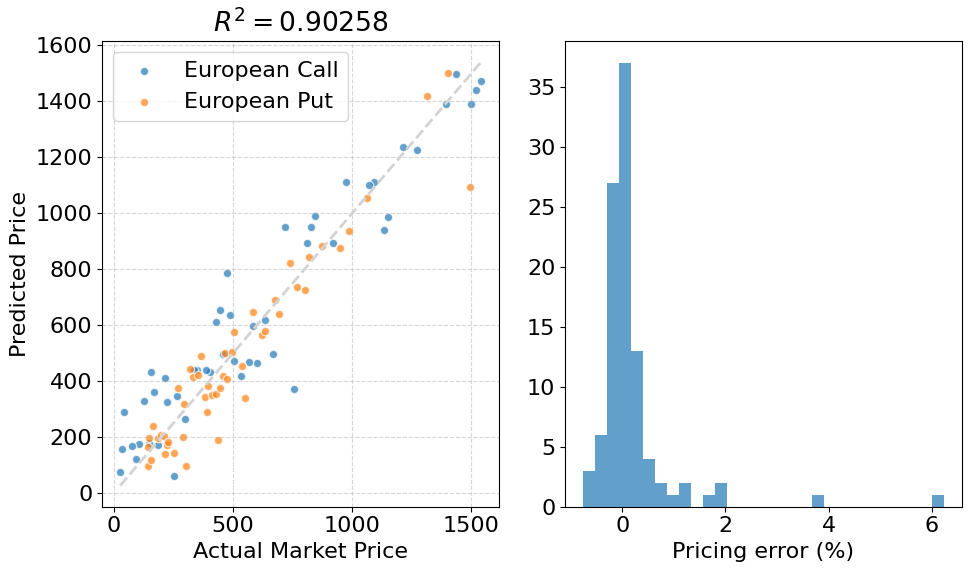

Saved plot to c:\Users\chris\VSCodeProjects\rough-path-signatures-pricing\img\SPX_Calibration.png


In [33]:
# --- Calibration to SPX Market Data ---
spx_data_path = PROJECT_DIR / "data" / "spx_call_put_100strikes.csv"

# 1. Load and Prepare SPX Data
full_spx_df = pd.read_csv(spx_data_path)

# Split: First 7 columns are Calls, Rest are Puts
df_calls_spx = full_spx_df.iloc[:, :7].copy()
df_puts_spx = full_spx_df.iloc[:, 7:].copy()
df_puts_spx.columns = df_puts_spx.columns.str[:-2]

# Config for SPX loop
spx_payoff_configs = [
    (european_call_payoff, "European_Call", df_calls_spx),
    (european_put_payoff, "European_Put", df_puts_spx),
]

print("--- Evaluating Model on SPX Data ---")

# Initialize Simulator
simulator = simulator = sm.GBM(**GBM_CONFIG)

model_results = []

# Iterate over Call/Put Data
for payoff_func, payoff_name, data_df in spx_payoff_configs:
    print(f"  Fitting {payoff_name}...")

    # Train/Test Split
    train_df = data_df.sample(frac=FRAC, random_state=SPLIT_SEED)
    test_df = data_df.drop(train_df.index).copy()

    X_train = train_df["Strike"].values
    y_train = train_df["Ask"].values
    X_test = test_df["Strike"].values
    y_test = test_df["Ask"].values

    # Fit Pricer
    pricer = sr.SignaturePricer(
        simulator=simulator, func=payoff_func, signature_degree=N
    )

    pricer.fit(X=X_train, y=y_train, n_paths=N_PATHS, lam=LAM)

    # Predict
    y_pred = pricer.predict(X=X_test)

    # Store
    test_df["predicted_price"] = y_pred
    test_df["payoff_type"] = payoff_name.replace("_", " ")
    model_results.append(test_df)

# Consolidate
full_model_df = pd.concat(model_results, ignore_index=True)

# Metrics
y_true_all = full_model_df["Ask"].values
y_pred_all = full_model_df["predicted_price"].values

ss_res = np.sum((y_true_all - y_pred_all) ** 2)
ss_tot = np.sum((y_true_all - np.mean(y_true_all)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Scatter Plot
ax_scatter = axes[0]
groups = full_model_df.groupby("payoff_type")
for name, group in groups:
    ax_scatter.scatter(
        group["Ask"],
        group["predicted_price"],
        label=name,
        alpha=0.7,
        edgecolors="w",
    )

# Identity Line
min_val = min(y_true_all.min(), y_pred_all.min())
max_val = max(y_true_all.max(), y_pred_all.max())
ax_scatter.plot([min_val, max_val], [min_val, max_val], "--", lw=2, color="lightgrey")

ax_scatter.set_xlabel("Actual Market Price")
ax_scatter.set_ylabel("Predicted Price")
ax_scatter.set_title(f"$R^2 = {r2:.5f}$")
ax_scatter.legend()
ax_scatter.grid(True, linestyle="--", alpha=0.5)

# Histogram
ax_hist = axes[1]
errors = (y_pred_all - y_true_all) / y_true_all
ax_hist.hist(errors, bins=30, alpha=0.7)
ax_hist.set_xlabel("Pricing error (%)")
ax_hist.set_ylabel("")
ax_hist.set_title("")

plt.tight_layout()

# Save
save_path = IMG_DIR / "SPX_Calibration.png"
plt.savefig(save_path)
plt.show()
print(f"Saved plot to {save_path}")